In [28]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
df = pd.read_csv('./data_root/clean_dataset.csv')

In [30]:
X = df.drop(['Country','Heart Attack Risk'],axis=1)
Y = df['Heart Attack Risk']

In [31]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [32]:
model = RandomForestClassifier()

model.fit(x_train, y_train)

RandomForestClassifier()

In [33]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

In [34]:
print("Treinamento:")
print(confusion_matrix(y_train, train_pred))
print("Teste:")
print(confusion_matrix(y_test, test_pred))

Treinamento:
[[4499    0]
 [   0 2511]]
Teste:
[[1105   20]
 [ 619    9]]


In [35]:
print(classification_report(y_test, test_pred, zero_division=1))
print(classification_report(y_train, train_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.64      0.98      0.78      1125
           1       0.31      0.01      0.03       628

    accuracy                           0.64      1753
   macro avg       0.48      0.50      0.40      1753
weighted avg       0.52      0.64      0.51      1753

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4499
           1       1.00      1.00      1.00      2511

    accuracy                           1.00      7010
   macro avg       1.00      1.00      1.00      7010
weighted avg       1.00      1.00      1.00      7010



## Observações do modelo inicial
Podemos observar que nosso modelo com dados normalizados e tratados sem hiperparâmetros teve uma acurâcia de 64% e recall baixo principalmente para risco de ataque cardíaco 1. Mostrando que temos poucas amostras para risco de ataque cardíaco e muitos de pessoas que não apresentaram essa condição. 

In [36]:
Y.value_counts()

Heart Attack Risk
0    5624
1    3139
Name: count, dtype: int64

### Random forest com undersample

In [37]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [38]:
rus = RandomUnderSampler(random_state=42)
x_train_resampled, y_train_resampled = rus.fit_resample(x_train, y_train)

print("Distribuição após undersampling:", y_train_resampled.value_counts())

Distribuição após undersampling: Heart Attack Risk
0    2511
1    2511
Name: count, dtype: int64


In [39]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid, cv=3, scoring='precision', n_jobs=-1)

grid_search.fit(x_train_resampled, y_train_resampled)
print(grid_search.best_params_)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [40]:
model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100)

model.fit(x_train_resampled, y_train_resampled)

RandomForestClassifier()

In [41]:
train_pred_under = model.predict(x_train)
test_pred_under = model.predict(x_test)

In [42]:
print(classification_report(y_test, test_pred_under, zero_division=1))
# print(classification_report(y_train, train_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.64      0.53      0.58      1125
           1       0.35      0.46      0.40       628

    accuracy                           0.51      1753
   macro avg       0.50      0.50      0.49      1753
weighted avg       0.54      0.51      0.52      1753



### Random forest com oversample

In [43]:
adasyn=ADASYN(sampling_strategy='minority',random_state = 42)
x_train_resampled_over, y_train_resampled_over = adasyn.fit_resample(x_train,y_train)

print("Distribuição após oversample:", y_train_resampled_over.value_counts())

Distribuição após oversample: Heart Attack Risk
0    4499
1    4383
Name: count, dtype: int64


In [44]:
model2 = RandomForestClassifier(n_estimators=300, max_depth=None,min_samples_leaf =1,min_samples_split=2, random_state=42)

model2.fit(x_train_resampled_over, y_train_resampled_over)

RandomForestClassifier(n_estimators=300, random_state=42)

In [45]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    estimator=model2, param_grid=param_grid, cv=3, scoring='recall', n_jobs=-1)

grid_search.fit(x_train_resampled_over, y_train_resampled_over)
print(grid_search.best_params_)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [46]:
train_pred_over = model2.predict(x_train)
test_pred_over = model2.predict(x_test)

print(classification_report(y_test, test_pred_over, zero_division=1))

              precision    recall  f1-score   support

           0       0.63      0.78      0.70      1125
           1       0.33      0.19      0.24       628

    accuracy                           0.57      1753
   macro avg       0.48      0.49      0.47      1753
weighted avg       0.53      0.57      0.54      1753



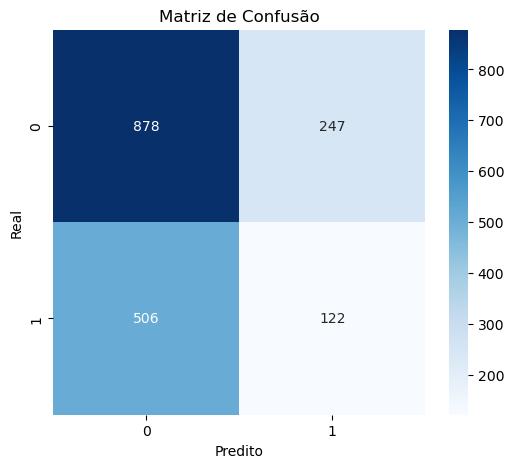

In [47]:
cm = confusion_matrix(y_test, test_pred_over)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

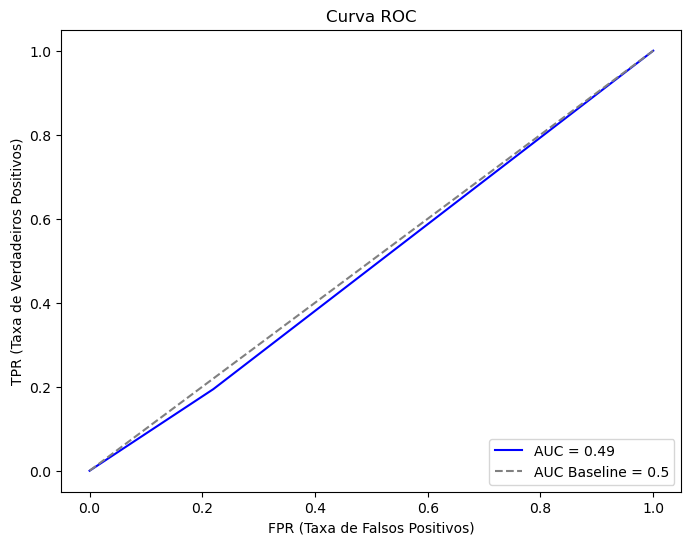

In [48]:
y_pred_proba = model.predict_proba(x_train)[:, 1]

fpr, tpr, _ = roc_curve(y_test, test_pred_over)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="AUC Baseline = 0.5")
plt.xlabel('FPR (Taxa de Falsos Positivos)')
plt.ylabel('TPR (Taxa de Verdadeiros Positivos)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Balanceando dataset e usando oversample

In [49]:
x_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y)

In [50]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    estimator=model2, param_grid=param_grid, cv=3, scoring='recall', n_jobs=-1)

grid_search.fit(x_train_balanced, y_train_balanced)
print(grid_search.best_params_)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [51]:
y_pred_balanced = model2.predict(X_test_balanced)

# Avaliação
print(classification_report(y_test_balanced, y_pred_balanced))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1125
           1       0.92      0.84      0.88       628

    accuracy                           0.92      1753
   macro avg       0.92      0.90      0.91      1753
weighted avg       0.92      0.92      0.92      1753



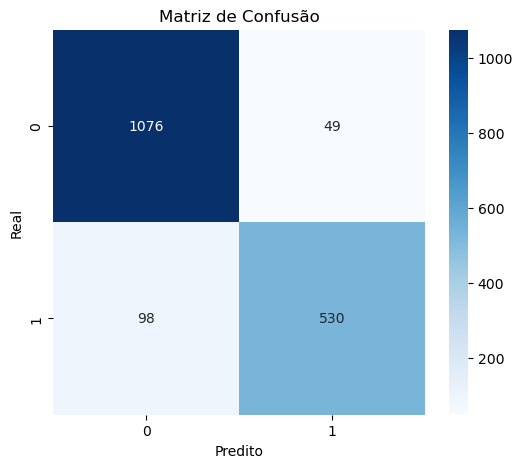

In [52]:
cm = confusion_matrix(y_test_balanced, y_pred_balanced)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

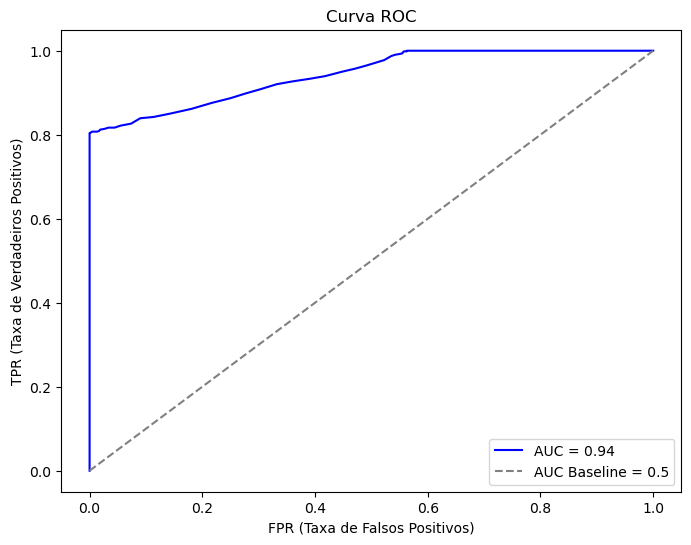

In [53]:
y_pred_proba = model.predict_proba(X_test_balanced)[:, 1]

fpr, tpr, _ = roc_curve(y_test_balanced, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="AUC Baseline = 0.5")
plt.xlabel('FPR (Taxa de Falsos Positivos)')
plt.ylabel('TPR (Taxa de Verdadeiros Positivos)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Usando undersample já balanceado

In [54]:
y_pred_balanced_under = model.predict(X_test_balanced)

# Avaliação
print(classification_report(y_test_balanced, y_pred_balanced_under))

              precision    recall  f1-score   support

           0       0.93      0.72      0.81      1125
           1       0.64      0.90      0.75       628

    accuracy                           0.79      1753
   macro avg       0.79      0.81      0.78      1753
weighted avg       0.83      0.79      0.79      1753



## Uso dos Hiperparâmetros e Modelo
Foi usado RandomForest pois existem muitas colunas condicionais com 0 e 1, sendo mais propicio usar arvores de decição aleatorias. Essas colunas com valores binários (0 ou 1) podem se destacar, pois o modelo pode identificar quais dessas variáveis têm maior impacto na classificação também.

Foram testados dois modelos de **RandomForest** para encontrar o melhor desempenho: um utilizando **oversampling** (aumento de dados da classe minoritária) e outro com **undersampling** (remoção de dados da classe majoritária). O melhor modelo foi o de **oversampling**, com dados balanceados utilizao **strafy**.

#### Modelo com Oversample (Melhor Modelo Encontrado):
**Melhores Parâmetros:**
- `'max_depth': None`
- `'min_samples_leaf': 1`
- `'min_samples_split': 2`
- `'n_estimators': 100`

**Explicação dos Parâmetros:**
- **max_depth**: **None** significa que não há limite para a profundidade das árvores, permitindo que elas cresçam sem restrições, o que é vantajoso quando o modelo precisa capturar padrões complexos e não deseja ser restrito a um limite máximo de profundidade.
- **min_samples_leaf**: **1**, assim como no modelo anterior, permite que a árvore seja criada com o menor número possível de amostras, o que pode ser útil quando se tem muitos dados.
- **min_samples_split**: **2**, valor padrão, permitindo a criação de divisões mesmo com poucas amostras.
- **n_estimators**: **100**, número de árvores no modelo, que oferece um bom equilíbrio entre performance e tempo de computação.

**Métricas:**
- **Recall**: 90%
- **Precisão**: 92%
- **Acurácia**: 92%

#### Modelo com Undersample:
**Melhores Parâmetros:**
- `'max_depth': 20`
- `'min_samples_leaf': 1`
- `'min_samples_split': 2`
- `'n_estimators': 100`

**Explicação dos Parâmetros:**
- **max_depth**:Um valor de **20** foi escolhido para evitar overfitting, pois árvores muito profundas podem se ajustar excessivamente aos dados de treino e comprometer a capacidade de generalização do modelo.
- **min_samples_leaf**: O valor **1** foi usado para permitir a criação de folhas com o menor número de amostras possível, o que pode ser útil em alguns casos para capturar padrões mais sutis.
- **min_samples_split**: O valor **2** foi escolhido para permitir divisões mais frequentes, o que pode gerar árvores mais complexas.
- **n_estimators**: **100** foi escolhido, pois é um valor que oferece um bom equilíbrio entre precisão e tempo de treinamento.

**Métricas:**
- **Recall**: 81%
- **Precisão**: 80%
- **Acurácia**: 79%

